In [182]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('evaluation.csv', header=None, names=['transaction_hash', 'num_events', 'time'])

In [183]:
# we can ignore the transactions with hundreds of events (col 2)
df = df[df["num_events"] < 100]

In [184]:
df_less_one_second = df[df["time"] < 1]
print(f"Number of rows with latency less than 1: {len(df_less_one_second)} ({len(df_less_one_second)/len(df)*100}%)")

df_more_one_second = df[df["time"] >= 1]
print(f"Number of rows with latency less than 1: {len(df_more_one_second)} ({len(df_more_one_second)/len(df)*100}%)")

max_latency = df["time"].max()
print(f"Max latency: {max_latency}")

Number of rows with latency less than 1: 738883 (90.4854043158208%)
Number of rows with latency less than 1: 77694 (9.514595684179202%)
Max latency: 138.15209197998047


In [185]:
# Load the file "transaction.facts" with 9 columns
df_transaction = pd.read_csv('../../../datalog/ronin-bridge/facts/transaction.facts', header=None, sep='\t', names=["timestamp", "chain_id", "transaction_hash", "transaction_index", "from", "to", "value", "status", "fee"], dtype={'col_6': str})
df_additional_transaction = pd.read_csv('../../../datalog/ronin-bridge/facts/additional_transaction.facts', header=None, sep='\t', names=["timestamp", "chain_id", "transaction_hash", "transaction_index", "from", "to", "value", "status", "fee"], dtype={'col_6': str})

# Append df_transaction and df_additional_transaction
df_transaction = pd.concat([df_transaction, df_additional_transaction], ignore_index=True)

df_transaction.to_csv('transaction.csv', index=False)

In [203]:
merged_df = df.merge(df_transaction[['transaction_hash', 'value']], how="left", on='transaction_hash')

merged_df.fillna(0, inplace=True)

In [204]:
merged_df['type'] = merged_df['value'].apply(lambda x: 'native' if int(x) > 0 else 'non-native')

merged_df.to_csv('output.csv', index=False)

In [206]:
df_native = merged_df[merged_df["type"] == "native"]
print(f"Number of rows with native token transfers: {len(df_native)} ({len(df_native)/len(merged_df)*100}%)")

df_non_native = merged_df[merged_df["type"] == "non-native"]
print(f"Number of rows with non-native token transfers: {len(df_non_native)} ({len(df_non_native)/len(merged_df)*100}%)")

Number of rows with native token transfers: 468997 (57.43451015642126%)
Number of rows with non-native token transfers: 347580 (42.565489843578746%)


In [189]:
# max latency of the non-native token transfers
max_latency_non_native = df_non_native["time"].max()
print(f"Max latency of the non-native token transfers: {max_latency_non_native}")

# min latency of the non-native token transfers
min_latency_non_native = df_non_native["time"].min()
print(f"Min latency of the non-native token transfers: {min_latency_non_native}")

# average latency of the non-native token transfers
average_latency_non_native = df_non_native["time"].mean()
print(f"Average latency of the non-native token transfers: {average_latency_non_native}")

# median latency of the non-native token transfers
average_latency_non_native = df_non_native["time"].median()
print(f"Median latency of the non-native token transfers: {average_latency_non_native}")

# standard deviation of the non-native token transfers
average_latency_non_native = df_non_native["time"].std()
print(f"Standard deviation of the non-native token transfers: {average_latency_non_native}")

Max latency of the non-native token transfers: 3.6477088928222656
Min latency of the non-native token transfers: 3.814697265625e-06
Average latency of the non-native token transfers: 0.28148541492411344
Median latency of the non-native token transfers: 0.22963547706604
Standard deviation of the non-native token transfers: 0.25898480461929696


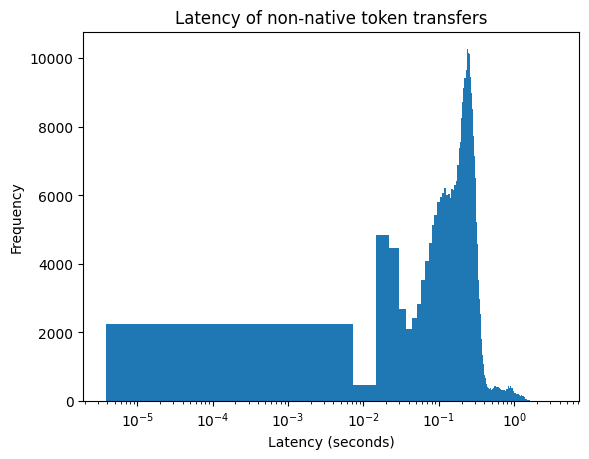

In [190]:
# plot the latency of the non-native token transfers
plt.hist(df_non_native["time"], bins=500)
plt.xlabel('Latency (seconds)')
plt.ylabel('Frequency')
#log scale in x
plt.xscale('log')
plt.title('Latency of non-native token transfers')
plt.show()

For the native tokens, we can estimate if they contained internal transactions or not

In [ ]:
# we have an internal transaction in the additional data for the ones that are in df_native and have only 1 event
add_internal_transactions = df_native[df_native["num_events"] == 1]

# max min avg median std of the internal transactions
max_latency_internal = add_internal_transactions["time"].max()
print(f"Max latency of the internal transactions: {max_latency_internal}")

min_latency_internal = add_internal_transactions["time"].min()
print(f"Min latency of the internal transactions: {min_latency_internal}")

average_latency_internal = add_internal_transactions["time"].mean()
print(f"Average latency of the internal transactions: {average_latency_internal}")

median_latency_internal = add_internal_transactions["time"].median()
print(f"Median latency of the internal transactions: {median_latency_internal}")

std_latency_internal = add_internal_transactions["time"].std()
print(f"Standard deviation of the internal transactions: {std_latency_internal}")

# count and percentage
print(f"Number of internal transactions: {len(add_internal_transactions)} ({len(add_internal_transactions)/len(df_native)*100}%)")

Max latency of the internal transactions: 138.15209197998047
Min latency of the internal transactions: 0.5939018726348877
Average latency of the internal transactions: 10.6549403794269
Median latency of the internal transactions: 9.318370819091797
Standard deviation of the internal transactions: 6.582374510537901
Number of internal transactions: 38521 (8.231739240998639%)


In [ ]:
# we have an internal transaction in the selected interval, for the ones that have a value in the tx but are not in the sc_deposit.facts or sc_withdraw.facts

sc_deposits = pd.read_csv('../../../datalog/ronin-bridge/facts/sc_deposit.facts', header=None, sep='\t', names=["transaction_hash", "event_index", "sender", "to", "amount"])
sc_withdrawal = pd.read_csv('../../../datalog/ronin-bridge/facts/sc_withdrawal.facts', header=None, sep='\t', names=["transaction_hash", "event_index", "from", "beneficiary", "amount"])

# collect and merge the tx hashes from the sc_deposits and sc_withdrawal
sc_deposits_tx = sc_deposits["transaction_hash"].unique()
sc_withdrawal_tx = sc_withdrawal["transaction_hash"].unique()
merged_tx_hashes = set(sc_deposits_tx).union(set(sc_withdrawal_tx))

# Filter transactions that have a value and are not in sc_deposits or sc_withdrawal
txs_with_value = df_native[
    (df_native['num_events'] == 2) &
    (~df_native['transaction_hash'].isin(merged_tx_hashes))
]

print(f"Number of internal transactions: {len(txs_with_value)}")


Number of internal transactions: 371732


In [ ]:
# max min avg median std of the internal transactions
max_latency_internal = txs_with_value["time"].max()
print(f"Max latency of the transaction: {max_latency_internal}")

min_latency_internal = txs_with_value["time"].min()
print(f"Min latency of the transaction: {min_latency_internal}")

average_latency_internal = txs_with_value["time"].mean()
print(f"Average latency of the transaction: {average_latency_internal}")

median_latency_internal = txs_with_value["time"].median()
print(f"Median latency of the transaction: {median_latency_internal}")

std_latency_internal = txs_with_value["time"].std()
print(f"Standard deviation of the transaction: {std_latency_internal}")

# count and percentage
print(f"Number of transactions: {len(txs_with_value)} ({len(txs_with_value)/len(df_native)*100}%)")

Max latency of the transaction: 12.941407442092896
Min latency of the transaction: 0.1838409900665283
Average latency of the transaction: 0.39287442970869535
Median latency of the transaction: 0.3431689739227295
Standard deviation of the transaction: 0.3356873545137753
Number of transactions: 371732 (79.4372132482258%)


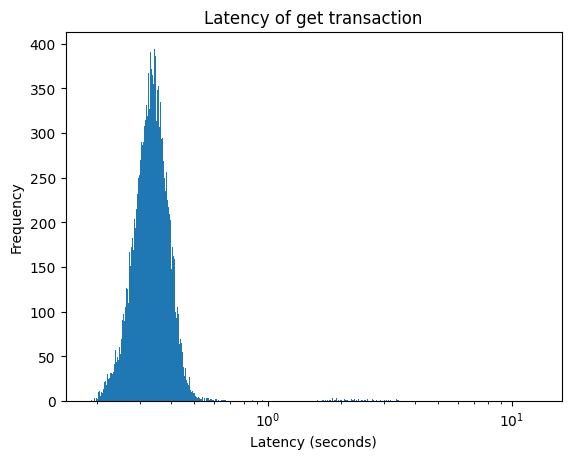

In [194]:
# plot the time of the internal transactions
plt.hist(txs_with_value["time"], bins=100000)
plt.xlabel('Latency (seconds)')
plt.ylabel('Frequency')
plt.xscale('log')
plt.title('Latency of get transaction')
plt.show()

In [ ]:
internal_txs = df_native[
    (df_native['num_events'] > 2) &
    (~df_native['transaction_hash'].isin(merged_tx_hashes))
]

len(internal_txs)

23

In [ ]:
# max min avg median std of the internal transactions
max_latency_internal = internal_txs["time"].max()
print(f"Max latency of internal transactions: {max_latency_internal}")

min_latency_internal = internal_txs["time"].min()
print(f"Min latency of internal transactions: {min_latency_internal}")

average_latency_internal = internal_txs["time"].mean()
print(f"Average latency of internal transactions: {average_latency_internal}")

median_latency_internal = internal_txs["time"].median()
print(f"Median latency of internal transactions: {median_latency_internal}")

std_latency_internal = internal_txs["time"].std()
print(f"Standard deviation of internal transactions: {std_latency_internal}")

# count and percentage
print(f"Number of internal transactions: {len(internal_txs)} ({len(internal_txs)/len(df_native)*100}%)")

Max latency of internal transactions: 19.18180894851685
Min latency of internal transactions: 1.9694130420684808
Average latency of internal transactions: 10.74094327636387
Median latency of internal transactions: 9.655467748641968
Standard deviation of internal transactions: 4.508611817429039
Number of internal transactions: 23 (0.004914981504710903%)


As we see, we do not have many transactions calling the "debug_trace" RPC method. Therefore, we are merging the data and presenting as a single dataset classified by making an external RPC request or not. Latency will be presented based on this difference.

In [207]:
datapoints = len(df_native)
print(f"Number of data points: {datapoints}")

max_latency = df_native["time"].max()
print(f"Max latency of the transaction: {max_latency}")

min_latency = df_native["time"].min()
print(f"Min latency of the transaction: {min_latency}")

average_latency = df_native["time"].mean()
print(f"Average latency of the transaction: {average_latency}")

median_latency = df_native["time"].median()
print(f"Median latency of the transaction: {median_latency}")

std_latency = df_native["time"].std()
print(f"Standard deviation of the transaction: {std_latency}")

Number of data points: 468997
Max latency of the transaction: 138.15209197998047
Min latency of the transaction: 0.1808810234069824
Average latency of the transaction: 1.8269345384780418
Median latency of the transaction: 0.3482890129089355
Standard deviation of the transaction: 4.698489754067609


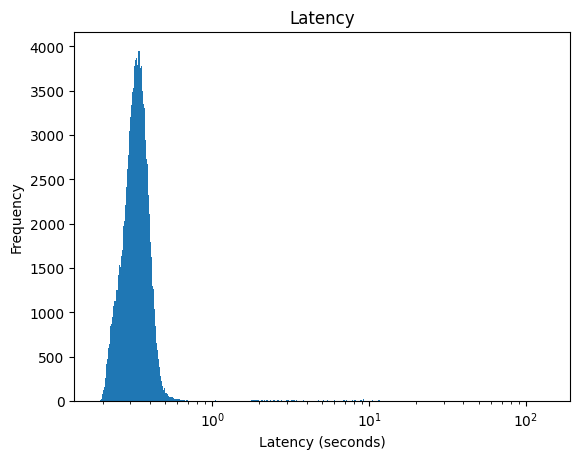

In [ ]:
plt.hist(df_native["time"], bins=100000)
plt.xlabel('Latency (seconds)')
plt.ylabel('Frequency')
plt.xscale('log')
plt.title('Latency')
plt.show()

In [208]:
(1.82*468997+347580*0.28)/60/60

264.1380388888889

In [211]:
# count how many of df_native have time > 1 and the percentage
df_native_time_gt_1 = df_native[df_native["time"] > 1]
print(f"Number of rows with latency greater than 1: {len(df_native_time_gt_1)} ({len(df_native_time_gt_1)/len(df_native)*100}%)")

# count how many of df_native have time > 10 and the percentage
df_native_time_gt_10 = df_native[df_native["time"] > 10]
print(f"Number of rows with latency greater than 10: {len(df_native_time_gt_10)} ({len(df_native_time_gt_10)/len(df_native)*100}%)")

# count how many of df_native have time > 10 and the percentage
df_native_time_gt_15 = df_native[df_native["time"] > 15]
print(f"Number of rows with latency greater than 15: {len(df_native_time_gt_15)} ({len(df_native_time_gt_15)/len(df_native)*100}%)")

Number of rows with latency greater than 1: 66197 (14.114589219120804%)
Number of rows with latency greater than 10: 30533 (6.510276185135512%)
Number of rows with latency greater than 15: 15429 (3.2897865018326344%)
